In [ ]:
from google.colab import files #модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных
import pandas as pd #библиотека для обработки и анализа данных
import matplotlib.pyplot as plt #библиотека для визуализации данных
import os
import csv
%matplotlib inline

from tensorflow.keras import utils #модуль с утилитами кераса, будем использовать для вызова метода преобразования категорий в вектора
from tensorflow.keras.models import Sequential 
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
# Загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split


import seaborn as sns
sns.set_style("whitegrid")


# Распознавание исмптомов различных забоелваний с использованием Эмбеддингов и различных архитектур нейронных сетей


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/drive/My Drive/Болезни.zip' -d /content/texts

#Предобработка

In [ ]:
def preprocessing(xlen=50, step=10):
    def readfile(x):
        with open(x, 'r') as f:
            text = f.read()
            text = text.lower()
            text = text.replace('\n\n',' ')
            text = text.replace('\n',' ')
            text = text.replace('\t',' ')
            text = text.replace('.','. ')
            text = text.replace(',',', ')
            text = text.replace('!','! ')
            text = text.replace('?','? ')
            text = text.replace(':',': ')
            text = text.replace(';','; ')
            text = text.replace('(','( ')
            text = text.replace(')',') ')
            text = text.replace('-','- ')
            return text

    texts = []
    classes = []
    for i in os.listdir('/content/texts/'):
        if  '.txt' in i:
          temp = readfile('/content/texts/' + i)
          texts.append(temp)
          classes.append(i[:-4])    
    Nclasses = len(classes)

    tokenizer = Tokenizer(num_words=1999, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)
    tokenizer.fit_on_texts(texts)
    print("Размер словаря", len(tokenizer.word_index.items()))
    print(tokenizer.word_index.items())
    tokens = tokenizer.texts_to_sequences(texts)


    def window(x, xlen, step): 
        result = [] 
        wordsLen = len(x)
        index = 0 
        while (index + xlen <= wordsLen):
          result.append(x[index:index+xlen])
          index += step 
        return result


    X = []
    all_results = []
    xlen=50 
    step=10
    N=0
    for i in range(Nclasses):
        
          temp1 = window(tokens[i], xlen, step)
          X.extend(temp1)
          temp2 = []
          for j in temp1:
            temp2.append(classes[i])
          all_results.extend(temp2)
          
    X = np.array(X)
    print(X.shape)

    encoder = LabelEncoder() 
    encoder.fit(all_results) 
    classesEncoded = encoder.transform(all_results) 
    print(encoder.classes_)
    print(classesEncoded.shape)
    print(classesEncoded[:5])

    Y = utils.to_categorical(classesEncoded, Nclasses+1)
    print(Y.shape) 
    print(Y[300])   

    print(X.shape)
    print(Y.shape)

    return X,Y

  

In [ ]:
X,Y = preprocessing(xlen=50, step=10)  

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify = Y)
x_Train = x_train
x_Test = x_test
print(x_Train.shape) 
print(y_train.shape)  
print(x_Test.shape) 
print(y_test.shape) 


# Embedding + LSTM сеть

In [ ]:
res = {}
for i in ['adam']:
    print("---------------i=",i, "----------------------------" )
    model = Sequential()
    model.add(Embedding(maxWordsCount, 1000, input_length=maxlen))
    model.add(SpatialDropout1D(0.3))
    model.add(BatchNormalization())

    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Bidirectional(LSTM(50)))
    model.add(Dropout(0.3))
    

    #model.add(Flatten())
    
    model.add(Dense(nClasses, activation='softmax'))

    model.compile(optimizer=i, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    #Обучаем сеть на xTrain
    history = model.fit(x_Train, 
                        y_train, 
                        epochs=10,
                        batch_size=5,
                        validation_data=(x_Test, y_test))
    res[i] = history.history['val_accuracy']

---------------i= adam ----------------------------
Epoch 1/10
125/125 [==============================] - 9s 37ms/step - loss: 2.0176 - accuracy: 0.3301 - val_loss: 2.8780 - val_accuracy: 0.2500
Epoch 2/10
125/125 [==============================] - 3s 28ms/step - loss: 0.3223 - accuracy: 0.9405 - val_loss: 0.7587 - val_accuracy: 0.7179
Epoch 3/10
125/125 [==============================] - 3s 27ms/step - loss: 0.0696 - accuracy: 0.9966 - val_loss: 0.0550 - val_accuracy: 0.9936
Epoch 4/10
125/125 [==============================] - 3s 27ms/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.0326 - val_accuracy: 0.9936
Epoch 5/10
125/125 [==============================] - 3s 27ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 0.9936
Epoch 6/10
125/125 [==============================] - 3s 27ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 7/10
125/125 [==============================] - 3s 27ms/step - loss: 0.0058 - accura

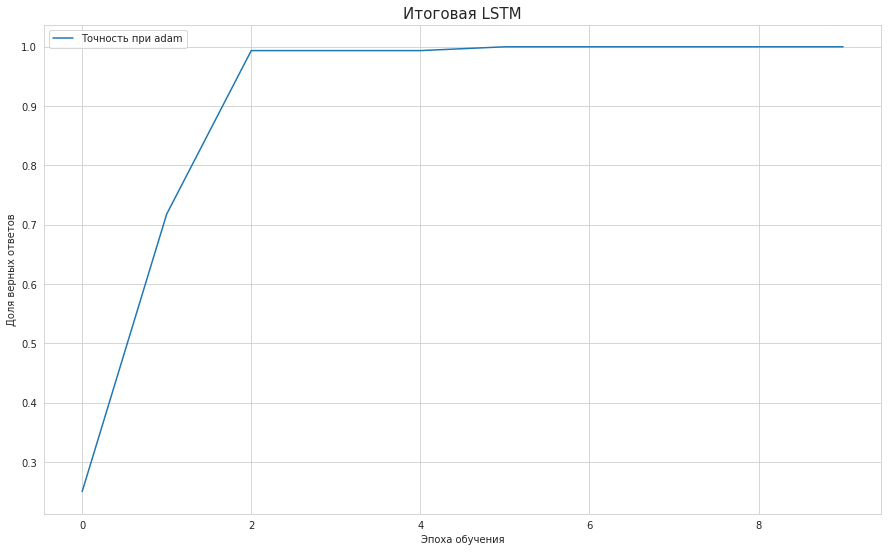

In [ ]:
plt.figure(figsize = (15,9))
for i in res:
  if i not in [10, 20, 500, 35, 300, 100, 70]:
    plt.plot(res[i] ,  label=f'Точность при {i}')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.title("Итоговая LSTM", size = 15)
plt.show()


In [ ]:
df_new = pd.DataFrame({'Class':encoder.inverse_transform(np.argmax(y_test, axis = 1))})


L = df_new['Class'].unique()
N_All = df_new.shape[0]
N_real = 0
for i in L:             
    
    df1 = df_new[df_new.Class==i]   #Делаю подвыборку датафрейма, только строки с нашими болезнями
    N = df1.shape[0]        #Общее количество записей
    indexes = list(df1.index)
    val = x_Test[indexes,:]    #Массив с описаниями болезней
    
    res = model.predict(val)                    #Предсказываю  
    res = np.argmax(res, axis = 1)            #Извлекаю номер класса предсказанного
    res = encoder.inverse_transform(res)        #Перевожу номер класса в название болезни
    n = sum(res == i)                         #Количество правильых ответов
    N_real = N_real + n
    print( f'Класс {i} -   точность ----------{n/N*100}, % ', '-----------Количество записей класса ', i, ': ', N)
print('В сумме', N_real/N_All*100, ' %')

Класс Панкреатит -   точность ----------100.0, %  -----------Количество записей класса  Панкреатит :  29
Класс Аппендицит -   точность ----------100.0, %  -----------Количество записей класса  Аппендицит :  11
Класс Гастрит -   точность ----------100.0, %  -----------Количество записей класса  Гастрит :  16
Класс Энтерит -   точность ----------100.0, %  -----------Количество записей класса  Энтерит :  16
Класс Колит -   точность ----------100.0, %  -----------Количество записей класса  Колит :  23
Класс Гепатит -   точность ----------100.0, %  -----------Количество записей класса  Гепатит :  13
Класс Холицестит -   точность ----------100.0, %  -----------Количество записей класса  Холицестит :  16
Класс Эзофагит -   точность ----------100.0, %  -----------Количество записей класса  Эзофагит :  15
Класс Дуоденит -   точность ----------100.0, %  -----------Количество записей класса  Дуоденит :  9
Класс Язва -   точность ----------100.0, %  -----------Количество записей класса  Язва :  8


#3) Свертка. + Embedding

In [ ]:
res = {}
for i in [1]:
    print("---------------i=",i, "----------------------------" )
    model = Sequential()
    model.add(Embedding(maxWordsCount, 2000, input_length=maxlen))
    model.add(SpatialDropout1D(0.3))
    model.add(BatchNormalization())

    model.add(Conv1D(150, 3, activation='relu')) 
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization()) 
    model.add(Conv1D(150, 3, activation='relu')) 
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))

    #model.add(Flatten())
    model.add(GlobalMaxPooling1D())
    model.add(Dense(nClasses, activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    #Обучаем сеть на xTrain
    print(model.summary())
    history = model.fit(x_Train, 
                        y_train, 
                        epochs=10,
                        batch_size=5,
                        validation_data=(x_Test, y_test))
    res[i] = history.history['val_accuracy']

---------------i= 1 ----------------------------
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 2000)          6000000   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 50, 2000)          0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 50, 2000)          8000      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 150)           900150    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 24, 150)           0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 24, 150)           0         
_________________________________________________________________
batch

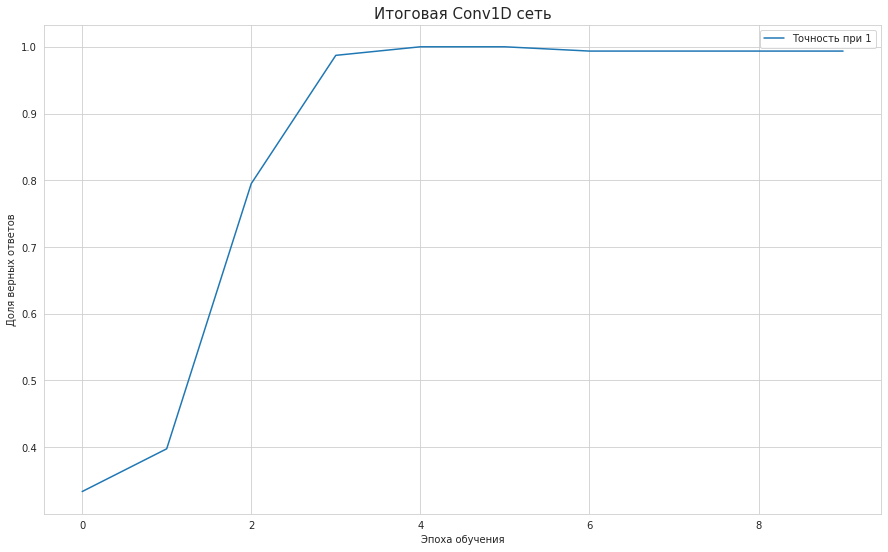

In [ ]:
plt.figure(figsize = (15,9))
for i in res:
  if i not in [-1]:
    plt.plot(res[i] ,  label=f'Точность при {i}')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.title("Итоговая Conv1D сеть", size = 15)
plt.show()


In [ ]:
df_new = pd.DataFrame({'Class':encoder.inverse_transform(np.argmax(y_test, axis = 1))})


L = df_new['Class'].unique()
N_All = df_new.shape[0]
N_real = 0
for i in L:             
    
    df1 = df_new[df_new.Class==i]   #Делаю подвыборку датафрейма, только строки с нашими болезнями
    N = df1.shape[0]        #Общее количество записей
    indexes = list(df1.index)
    val = x_Test[indexes,:]    #Массив с описаниями болезней
    
    res = model.predict(val)                    #Предсказываю  
    res = np.argmax(res, axis = 1)            #Извлекаю номер класса предсказанного
    res = encoder.inverse_transform(res)        #Перевожу номер класса в название болезни
    n = sum(res == i)                         #Количество правильых ответов
    N_real = N_real + n
    print( f'Класс {i} -   точность ----------{n/N*100}, % ', '-----------Количество записей класса ', i, ': ', N)
print('В сумме', N_real/N_All*100, ' %')

Класс Панкреатит -   точность ----------100.0, %  -----------Количество записей класса  Панкреатит :  29
Класс Аппендицит -   точность ----------100.0, %  -----------Количество записей класса  Аппендицит :  11
Класс Гастрит -   точность ----------93.75, %  -----------Количество записей класса  Гастрит :  16
Класс Энтерит -   точность ----------100.0, %  -----------Количество записей класса  Энтерит :  16
Класс Колит -   точность ----------100.0, %  -----------Количество записей класса  Колит :  23
Класс Гепатит -   точность ----------100.0, %  -----------Количество записей класса  Гепатит :  13
Класс Холицестит -   точность ----------100.0, %  -----------Количество записей класса  Холицестит :  16
Класс Эзофагит -   точность ----------100.0, %  -----------Количество записей класса  Эзофагит :  15
Класс Дуоденит -   точность ----------100.0, %  -----------Количество записей класса  Дуоденит :  9
Класс Язва -   точность ----------100.0, %  -----------Количество записей класса  Язва :  8


#4) Embedding + сложная сеть из Dense, LSTM и Conv1D

In [ ]:
res = {}
for i in [1]:
    print("---------------i=",i, "----------------------------" )
    model = Sequential()
    model.add(Embedding(maxWordsCount, 2000, input_length=maxlen))
    model.add(SpatialDropout1D(0.3))
    model.add(BatchNormalization())

    model.add(Conv1D(150, 3, activation='relu')) 
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization()) 
    model.add(Conv1D(150, 3, activation='relu')) 
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Bidirectional(LSTM(50)))
    model.add(Dropout(0.3))

    #model.add(Flatten())
    #model.add(GlobalMaxPooling1D())
    model.add(Dense(nClasses, activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    #Обучаем сеть на xTrain
    print(model.summary())
    history = model.fit(x_Train, 
                        y_train, 
                        epochs=10,
                        batch_size=5,
                        validation_data=(x_Test, y_test))
    res[i] = history.history['val_accuracy']

---------------i= 1 ----------------------------
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 2000)          6000000   
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 50, 2000)          0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 50, 2000)          8000      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 48, 150)           900150    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 24, 150)           0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 24, 150)           0         
_________________________________________________________________
batc

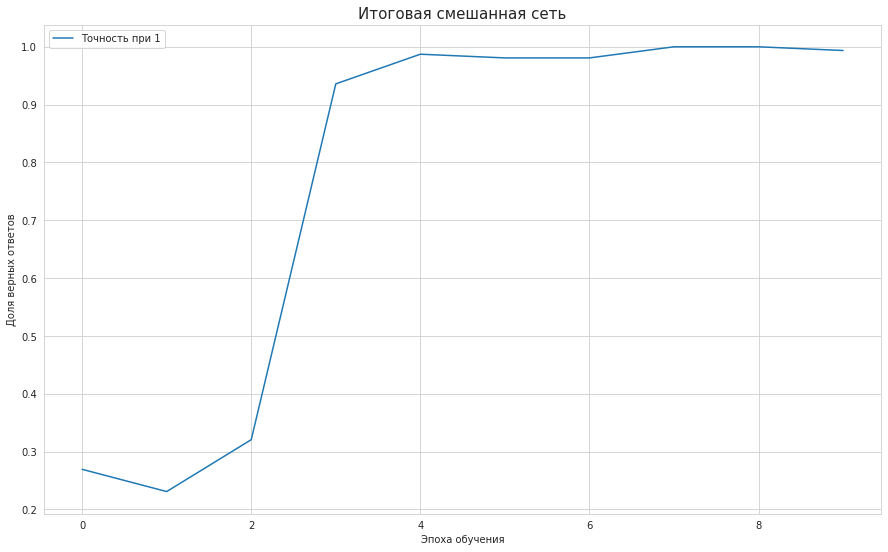

In [ ]:
plt.figure(figsize = (15,9))
for i in res:
  
    plt.plot(res[i] ,  label=f'Точность при {i}')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.title("Итоговая смешанная сеть", size = 15)
plt.show()


In [ ]:
df_new = pd.DataFrame({'Class':encoder.inverse_transform(np.argmax(y_test, axis = 1))})


L = df_new['Class'].unique()
N_All = df_new.shape[0]
N_real = 0
for i in L:             
    
    df1 = df_new[df_new.Class==i]   #Делаю подвыборку датафрейма, только строки с нашими болезнями
    N = df1.shape[0]        #Общее количество записей
    indexes = list(df1.index)
    val = x_Test[indexes,:]    #Массив с описаниями болезней
    
    res = model.predict(val)                    #Предсказываю  
    res = np.argmax(res, axis = 1)            #Извлекаю номер класса предсказанного
    res = encoder.inverse_transform(res)        #Перевожу номер класса в название болезни
    n = sum(res == i)                         #Количество правильых ответов
    N_real = N_real + n
    print( f'Класс {i} -   точность ----------{n/N*100}, % ', '-----------Количество записей класса ', i, ': ', N)
print('В сумме', N_real/N_All*100, ' %')

Класс Панкреатит -   точность ----------96.55172413793103, %  -----------Количество записей класса  Панкреатит :  29
Класс Аппендицит -   точность ----------100.0, %  -----------Количество записей класса  Аппендицит :  11
Класс Гастрит -   точность ----------100.0, %  -----------Количество записей класса  Гастрит :  16
Класс Энтерит -   точность ----------100.0, %  -----------Количество записей класса  Энтерит :  16
Класс Колит -   точность ----------100.0, %  -----------Количество записей класса  Колит :  23
Класс Гепатит -   точность ----------100.0, %  -----------Количество записей класса  Гепатит :  13
Класс Холицестит -   точность ----------100.0, %  -----------Количество записей класса  Холицестит :  16
Класс Эзофагит -   точность ----------100.0, %  -----------Количество записей класса  Эзофагит :  15
Класс Дуоденит -   точность ----------100.0, %  -----------Количество записей класса  Дуоденит :  9
Класс Язва -   точность ----------100.0, %  -----------Количество записей класса